In [1]:
# Import libraries

import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import plot_model



import tensorflow_datasets as tfds

In [2]:
# Load the data

p_camelyon, p_camelyon_info = tfds.load("patch_camelyon", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete0O3AZW/patch_camelyon-test.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete0O3AZW/patch_camelyon-train.tfrecord


  0%|          | 0/262144 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incomplete0O3AZW/patch_camelyon-validation.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


In [3]:
# Defining a "normalize" function to process the data before feeding it into the deep neural network. 

def normalize(x):
  image, label = x['image'], x['label']
  image = tf.image.convert_image_dtype(image, tf.float32)
  label = tf.one_hot(label, 2, dtype=tf.float32)
  return image, label

In [4]:
# Applying "normalize" function along with others to the data

# Processing the training dataset
train_ds = p_camelyon['train'].map(normalize, num_parallel_calls=8)
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(64)
train_ds = train_ds.prefetch(2)

# Processing validation dataset
validation_ds = p_camelyon['validation'].map(normalize, num_parallel_calls=8)
validation_ds = validation_ds.repeat()
validation_ds = validation_ds.batch(128)
validation_ds = validation_ds.prefetch(2)

#Processing the test dataset
test_ds = p_camelyon['test'].map(normalize, num_parallel_calls=8)
test_ds = test_ds.batch(128)
test_ds = test_ds.prefetch(2)

#Seperating image and label into different variables
train_images, train_labels = next(iter(train_ds))
valid_images, valid_labels = next(iter(validation_ds))
test_images, test_labels  = next(iter(test_ds))


In [5]:
import math

batch_size_for_training = 64
batch_size_for_validation = 128
batch_size_for_test = 128

training_size = 262144
validation_size = 32768
test_size =  32768
        

# Calculate steps for training and testing the model
calculate_steps_training = lambda x: int(math.ceil(1. * x / batch_size_for_training))
calculate_steps_validation = lambda x: int(math.ceil(1. * x / batch_size_for_validation))
calculate_steps_test= lambda x: int(math.ceil(1. * x / batch_size_for_test))

steps_per_epoch = calculate_steps_training(training_size) 
validation_steps = calculate_steps_validation(validation_size)
steps = calculate_steps_test(test_size)

print("Training steps: ", steps_per_epoch)
print("Validation steps: ", validation_steps)
print("Testing steps: ", steps)


Training steps:  4096
Validation steps:  256
Testing steps:  256


In [6]:
import matplotlib.pyplot as plt

def plot_hist(history):
  plt.plot(history.history["acc"])
  plt.plot(history.history["val_acc"])
  plt.title("Model Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 16)        4624      
                                                             

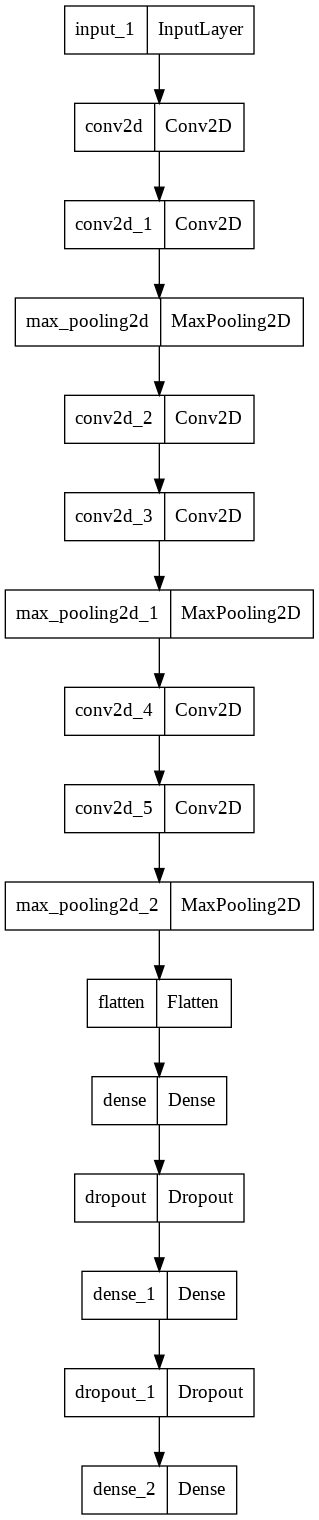

In [7]:
# Building the Convolutonal Nueral Network Model 1.1.1 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Relu activation functions only, with softmax activation function for the last Dense layer
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = sgd
# Loss function = hinge
model_1_1_1_version_2 = Model(inputs=input, outputs = output)
model_1_1_1_version_2.compile(optimizer='sgd', 
              loss=tf.keras.losses.Hinge(),
              metrics=['acc'])

model_1_1_1_version_2.summary()
plot_model(model_1_1_1_version_2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 94, 94, 16)        448       
                                                                 
 conv2d_7 (Conv2D)           (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 44, 44, 32)        4640      
                                                                 
 conv2d_9 (Conv2D)           (None, 42, 42, 16)        4624      
                                                           

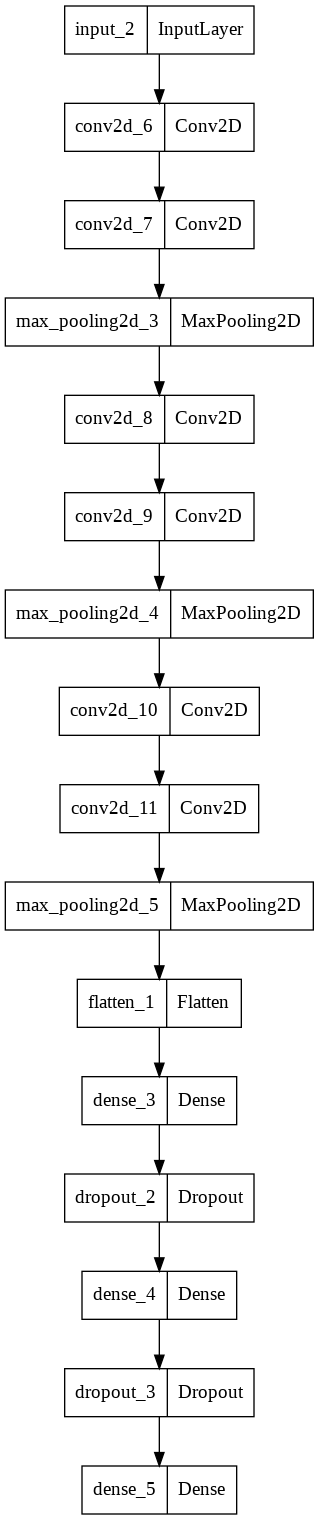

In [8]:
# Building the Convolutonal Nueral Network Model 1.1.2 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Relu activation functions only, with softmax activation function for the last Dense layer
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adagrad
# Loss function = hinge
model_1_1_2_version_2 = Model(inputs=input, outputs = output)
model_1_1_2_version_2.compile(optimizer='adagrad', 
              loss=tf.keras.losses.Hinge(),
              metrics=['acc'])

model_1_1_2_version_2.summary()
plot_model(model_1_1_2_version_2)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 conv2d_13 (Conv2D)          (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 16)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 44, 44, 32)        4640      
                                                                 
 conv2d_15 (Conv2D)          (None, 42, 42, 16)        4624      
                                                           

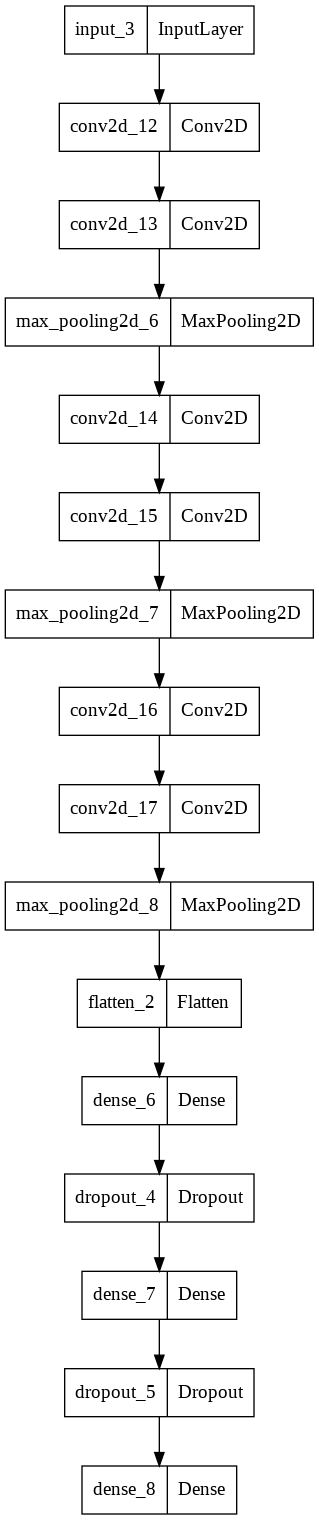

In [9]:
# Building the Convolutonal Nueral Network Model 1.1.3 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Relu activation functions only, with softmax activation function for the last Dense layer
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = RMSprop
# Loss function = hinge
model_1_1_3_version_2 = Model(inputs=input, outputs = output)
model_1_1_3_version_2.compile(optimizer='RMSprop', 
              loss=tf.keras.losses.Hinge(),
              metrics=['acc'])

model_1_1_3_version_2.summary()
plot_model(model_1_1_3_version_2)

In [10]:
# Building the Convolutonal Nueral Network Model 1.2.1 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Relu activation functions only, with softmax activation function for the last Dense layer
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = sgd
# Loss function =   MSE
model_1_2_1_version_2 = Model(inputs=input, outputs = output)
model_1_2_1_version_2.compile(optimizer='sgd', 
              loss='MSE',
              metrics=['acc'])

model_1_2_1_version_2.summary()
#plot_model(model_1_2_1_version_2)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 conv2d_19 (Conv2D)          (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 46, 46, 16)       0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 44, 44, 32)        4640      
                                                                 
 conv2d_21 (Conv2D)          (None, 42, 42, 16)        4624      
                                                           

In [11]:
# Building the Convolutonal Nueral Network Model 1.2.2 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Relu activation functions only, with softmax activation function for the last Dense layer
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adagrad
# Loss function =   MSE
model_1_2_2_version_2 = Model(inputs=input, outputs = output)
model_1_2_2_version_2.compile(optimizer='adagrad', 
              loss='MSE',
              metrics=['acc'])

model_1_2_2_version_2.summary()
#plot_model(model_1_2_2_version_2)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 conv2d_25 (Conv2D)          (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 44, 44, 32)        4640      
                                                                 
 conv2d_27 (Conv2D)          (None, 42, 42, 16)        4624      
                                                           

In [12]:
# Building the Convolutonal Nueral Network Model 1.2.3 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Relu activation functions only, with softmax activation function for the last Dense layer
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = RMSprop
# Loss function =   MSE
model_1_2_3_version_2 = Model(inputs=input, outputs = output)
model_1_2_3_version_2.compile(optimizer='RMSprop', 
              loss='MSE',
              metrics=['acc'])

model_1_2_3_version_2.summary()
#plot_model(model_1_2_3_version_2)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 conv2d_31 (Conv2D)          (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 44, 44, 32)        4640      
                                                                 
 conv2d_33 (Conv2D)          (None, 42, 42, 16)        4624      
                                                           

In [13]:
# Building the Convolutonal Nueral Network Model 2.1.1 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Sigmoid activation functions only with softmax for the last Dense layer

x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = sgd
# Loss function = hinge
model_2_1_1_version_2 = Model(inputs=input, outputs = output)
model_2_1_1_version_2.compile(optimizer='sgd', 
              loss=tf.keras.losses.Hinge(),
              metrics=['acc'])

model_2_1_1_version_2.summary()
#plot_model(model_2_1_1_version_2)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 conv2d_37 (Conv2D)          (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 44, 44, 32)        4640      
                                                                 
 conv2d_39 (Conv2D)          (None, 42, 42, 16)        4624      
                                                           

In [35]:
# Building the Convolutonal Nueral Network Model 2.1.2 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Sigmoid activation functions only with softmax for the last Dense layer

x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adagrad
# Loss function = hinge
model_2_1_2_version_2 = Model(inputs=input, outputs = output)
model_2_1_2_version_2.compile(optimizer='adagrad', 
              loss=tf.keras.losses.Hinge(),
              metrics=['acc'])

model_2_1_2_version_2.summary()
#plot_model(model_2_1_2_version_2)

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_108 (Conv2D)         (None, 94, 94, 16)        448       
                                                                 
 conv2d_109 (Conv2D)         (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_54 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_110 (Conv2D)         (None, 44, 44, 32)        4640      
                                                                 
 conv2d_111 (Conv2D)         (None, 42, 42, 16)        4624      
                                                          

In [39]:
# Building the Convolutonal Nueral Network Model 2.1.3 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Sigmoid activation functions only with softmax for the last Dense layer

x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = RMSprop
# Loss function = hinge
model_2_1_3_version_2 = Model(inputs=input, outputs = output)
model_2_1_3_version_2.compile(optimizer='RMSprop', 
              loss=tf.keras.losses.Hinge(),
              metrics=['acc'])

model_2_1_3_version_2.summary()
#plot_model(model_2_1_3_version_2)

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_114 (Conv2D)         (None, 94, 94, 16)        448       
                                                                 
 conv2d_115 (Conv2D)         (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_116 (Conv2D)         (None, 44, 44, 32)        4640      
                                                                 
 conv2d_117 (Conv2D)         (None, 42, 42, 16)        4624      
                                                          

In [40]:
# Building the Convolutonal Nueral Network Model 2.2.1 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Sigmoid activation functions only with softmax for the last Dense layer

x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = sgd
# Loss function = MSE
model_2_2_1_version_2 = Model(inputs=input, outputs = output)
model_2_2_1_version_2.compile(optimizer='sgd', 
              loss='MSE',
              metrics=['acc'])

model_2_2_1_version_2.summary()
#plot_model(model_2_2_1_version_2)

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_120 (Conv2D)         (None, 94, 94, 16)        448       
                                                                 
 conv2d_121 (Conv2D)         (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_122 (Conv2D)         (None, 44, 44, 32)        4640      
                                                                 
 conv2d_123 (Conv2D)         (None, 42, 42, 16)        4624      
                                                          

In [41]:
# Building the Convolutonal Nueral Network Model 2.2.2 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Sigmoid activation functions only with softmax for the last Dense layer

x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adagrad
# Loss function = MSE
model_2_2_2_version_2 = Model(inputs=input, outputs = output)
model_2_2_2_version_2.compile(optimizer='adagrad', 
              loss='MSE',
              metrics=['acc'])

model_2_2_2_version_2.summary()
#plot_model(model_2_2_2_version_2)

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_126 (Conv2D)         (None, 94, 94, 16)        448       
                                                                 
 conv2d_127 (Conv2D)         (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_128 (Conv2D)         (None, 44, 44, 32)        4640      
                                                                 
 conv2d_129 (Conv2D)         (None, 42, 42, 16)        4624      
                                                          

In [42]:
# Building the Convolutonal Nueral Network Model 2.2.3 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Sigmoid activation functions only with softmax for the last Dense layer

x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = RMSprop
# Loss function = MSE
model_2_2_3_version_2 = Model(inputs=input, outputs = output)
model_2_2_3_version_2.compile(optimizer='RMSprop', 
              loss='MSE',
              metrics=['acc'])

model_2_2_3_version_2.summary()
#plot_model(model_2_2_3_version_2)

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_132 (Conv2D)         (None, 94, 94, 16)        448       
                                                                 
 conv2d_133 (Conv2D)         (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_134 (Conv2D)         (None, 44, 44, 32)        4640      
                                                                 
 conv2d_135 (Conv2D)         (None, 42, 42, 16)        4624      
                                                          

In [43]:
# Building the Convolutonal Neural Network Model 3.1.1 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# A conbination of relu and sigmoid activation functions
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = sgd
# Loss function = hinge
model_3_1_1_version_2 = Model(inputs=input, outputs = output)
model_3_1_1_version_2.compile(optimizer='sgd', 
              loss=tf.keras.losses.Hinge(),
              metrics=['acc'])

model_3_1_1_version_2.summary()
#plot_model(model_3_1_1_version_2)

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_138 (Conv2D)         (None, 94, 94, 16)        448       
                                                                 
 conv2d_139 (Conv2D)         (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_140 (Conv2D)         (None, 44, 44, 32)        4640      
                                                                 
 conv2d_141 (Conv2D)         (None, 42, 42, 32)        9248      
                                                          

In [44]:
# Building the Convolutonal Neural Network Model 3.1.2 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# A conbination of relu and sigmoid activation functions
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adagrad
# Loss function = hinge
model_3_1_2_version_2 = Model(inputs=input, outputs = output)
model_3_1_2_version_2.compile(optimizer='adagrad', 
              loss=tf.keras.losses.Hinge(),
              metrics=['acc'])

model_3_1_2_version_2.summary()
#plot_model(model_3_1_2_version_2)

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_144 (Conv2D)         (None, 94, 94, 16)        448       
                                                                 
 conv2d_145 (Conv2D)         (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_146 (Conv2D)         (None, 44, 44, 32)        4640      
                                                                 
 conv2d_147 (Conv2D)         (None, 42, 42, 32)        9248      
                                                          

In [45]:
# Building the Convolutonal Neural Network Model 3.1.3 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# A conbination of relu and sigmoid activation functions
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = RMSprop
# Loss function = hinge
model_3_1_3_version_2 = Model(inputs=input, outputs = output)
model_3_1_3_version_2.compile(optimizer='RMSprop', 
              loss=tf.keras.losses.Hinge(),
              metrics=['acc'])

model_3_1_3_version_2.summary()
#plot_model(model_3_1_3_version_2)

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_150 (Conv2D)         (None, 94, 94, 16)        448       
                                                                 
 conv2d_151 (Conv2D)         (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_152 (Conv2D)         (None, 44, 44, 32)        4640      
                                                                 
 conv2d_153 (Conv2D)         (None, 42, 42, 32)        9248      
                                                          

In [46]:
# Building the Convolutonal Neural Network Model 3.2.1 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# A conbination of relu and sigmoid activation functions
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = sgd
# Loss function = MSE
model_3_2_1_version_2 = Model(inputs=input, outputs = output)
model_3_2_1_version_2.compile(optimizer='sgd', 
              loss='MSE',
              metrics=['acc'])

model_3_2_1_version_2.summary()
#plot_model(model_3_2_1_version_2)

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_156 (Conv2D)         (None, 94, 94, 16)        448       
                                                                 
 conv2d_157 (Conv2D)         (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_158 (Conv2D)         (None, 44, 44, 32)        4640      
                                                                 
 conv2d_159 (Conv2D)         (None, 42, 42, 32)        9248      
                                                          

In [47]:
# Building the Convolutonal Neural Network Model 3.2.2 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# A conbination of relu and sigmoid activation functions
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adagrad
# Loss function = MSE
model_3_2_2_version_2 = Model(inputs=input, outputs = output)
model_3_2_2_version_2.compile(optimizer='adagrad', 
              loss='MSE',
              metrics=['acc'])

model_3_2_2_version_2.summary()
#plot_model(model_3_2_2_version_2)

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_162 (Conv2D)         (None, 94, 94, 16)        448       
                                                                 
 conv2d_163 (Conv2D)         (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_164 (Conv2D)         (None, 44, 44, 32)        4640      
                                                                 
 conv2d_165 (Conv2D)         (None, 42, 42, 32)        9248      
                                                          

In [48]:
# Building the Convolutonal Neural Network Model 3.2.3 (Version 2)

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# A conbination of relu and sigmoid activation functions
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(input)
x = Conv2D(16, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = Conv2D(64, (3,3), activation='sigmoid', padding='valid')(x)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='sigmoid')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = RMSprop
# Loss function = MSE
model_3_2_3_version_2 = Model(inputs=input, outputs = output)
model_3_2_3_version_2.compile(optimizer='RMSprop', 
              loss='MSE',
              metrics=['acc'])

model_3_2_3_version_2.summary()
#plot_model(model_3_2_3_version_2)

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_168 (Conv2D)         (None, 94, 94, 16)        448       
                                                                 
 conv2d_169 (Conv2D)         (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 46, 46, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_170 (Conv2D)         (None, 44, 44, 32)        4640      
                                                                 
 conv2d_171 (Conv2D)         (None, 42, 42, 32)        9248      
                                                          

Epoch 1/10
4096/4096 [==============================] - 118s 26ms/step - loss: 0.9134 - acc: 0.5930 - val_loss: 0.8428 - val_acc: 0.6569
Epoch 2/10
4096/4096 [==============================] - 102s 25ms/step - loss: 0.8219 - acc: 0.6792 - val_loss: 0.7595 - val_acc: 0.7414
Epoch 3/10
4096/4096 [==============================] - 103s 25ms/step - loss: 0.7301 - acc: 0.7710 - val_loss: 0.7289 - val_acc: 0.7709
Epoch 4/10
4096/4096 [==============================] - 127s 31ms/step - loss: 0.7074 - acc: 0.7936 - val_loss: 0.7249 - val_acc: 0.7747
Epoch 5/10
4096/4096 [==============================] - 124s 30ms/step - loss: 0.6912 - acc: 0.8098 - val_loss: 0.7250 - val_acc: 0.7744
Epoch 6/10
4096/4096 [==============================] - 104s 25ms/step - loss: 0.6849 - acc: 0.8159 - val_loss: 0.7057 - val_acc: 0.7952
Epoch 7/10
4096/4096 [==============================] - 110s 27ms/step - loss: 0.6823 - acc: 0.8182 - val_loss: 0.7181 - val_acc: 0.7831
Epoch 8/10
4096/4096 [===================

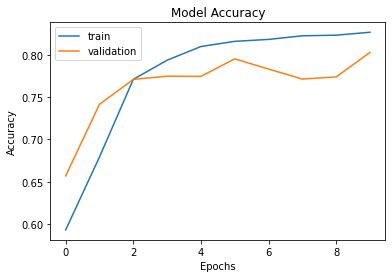

In [25]:
# Training the model 1.1.1 (Version 2)

history_1_1_1_version_2= model_1_1_1_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_1_1_1_version_2)

Epoch 1/10
4096/4096 [==============================] - 107s 26ms/step - loss: 0.8694 - acc: 0.6708 - val_loss: 0.7572 - val_acc: 0.7456
Epoch 2/10
4096/4096 [==============================] - 103s 25ms/step - loss: 0.7364 - acc: 0.7670 - val_loss: 0.7529 - val_acc: 0.7490
Epoch 3/10
4096/4096 [==============================] - 124s 30ms/step - loss: 0.7304 - acc: 0.7715 - val_loss: 0.7496 - val_acc: 0.7512
Epoch 4/10
4096/4096 [==============================] - 102s 25ms/step - loss: 0.7276 - acc: 0.7741 - val_loss: 0.7538 - val_acc: 0.7466
Epoch 5/10
4096/4096 [==============================] - 107s 26ms/step - loss: 0.7254 - acc: 0.7761 - val_loss: 0.7526 - val_acc: 0.7480
Epoch 6/10
4096/4096 [==============================] - 110s 27ms/step - loss: 0.7237 - acc: 0.7776 - val_loss: 0.7514 - val_acc: 0.7498
Epoch 7/10
4096/4096 [==============================] - 103s 25ms/step - loss: 0.7226 - acc: 0.7787 - val_loss: 0.7472 - val_acc: 0.7519
Epoch 8/10
4096/4096 [===================

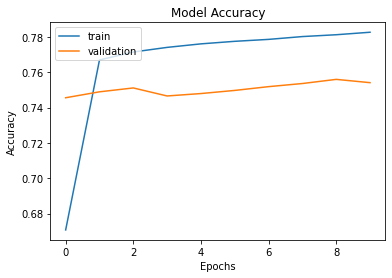

In [26]:
# Training the model 1.1.2 (Version 2)

history_1_1_2_version_2= model_1_1_2_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_1_1_2_version_2)

Epoch 1/10
4096/4096 [==============================] - 107s 26ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 2/10
4096/4096 [==============================] - 103s 25ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 3/10
4096/4096 [==============================] - 125s 31ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 4/10
4096/4096 [==============================] - 104s 25ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 5/10
4096/4096 [==============================] - 107s 26ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 6/10
4096/4096 [==============================] - 109s 27ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 7/10
4096/4096 [==============================] - 108s 26ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 8/10
4096/4096 [===================

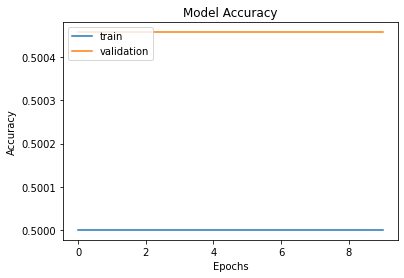

In [27]:
# Training the model 1.1.3 (Version 2)

history_1_1_3_version_2= model_1_1_3_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_1_1_3_version_2)

Epoch 1/10
4096/4096 [==============================] - 103s 25ms/step - loss: 0.1844 - acc: 0.7284 - val_loss: 0.1543 - val_acc: 0.7719
Epoch 2/10
4096/4096 [==============================] - 100s 24ms/step - loss: 0.1493 - acc: 0.7907 - val_loss: 0.1439 - val_acc: 0.7915
Epoch 3/10
4096/4096 [==============================] - 127s 31ms/step - loss: 0.1393 - acc: 0.8060 - val_loss: 0.1369 - val_acc: 0.8078
Epoch 4/10
4096/4096 [==============================] - 123s 30ms/step - loss: 0.1292 - acc: 0.8215 - val_loss: 0.1290 - val_acc: 0.8154
Epoch 5/10
4096/4096 [==============================] - 101s 25ms/step - loss: 0.1224 - acc: 0.8315 - val_loss: 0.2019 - val_acc: 0.7005
Epoch 6/10
4096/4096 [==============================] - 103s 25ms/step - loss: 0.1174 - acc: 0.8384 - val_loss: 0.1663 - val_acc: 0.7580
Epoch 7/10
4096/4096 [==============================] - 101s 25ms/step - loss: 0.1128 - acc: 0.8447 - val_loss: 0.1256 - val_acc: 0.8218
Epoch 8/10
4096/4096 [===================

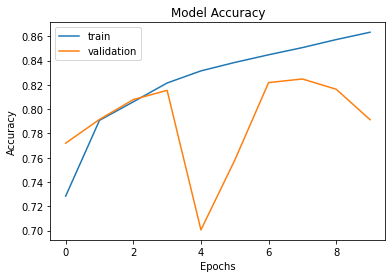

In [28]:
# Training the model 1.2.1 (Version 2)

history_1_2_1_version_2= model_1_2_1_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_1_2_1_version_2)

Epoch 1/10
4096/4096 [==============================] - 113s 27ms/step - loss: 0.1377 - acc: 0.8082 - val_loss: 0.1554 - val_acc: 0.7788
Epoch 2/10
4096/4096 [==============================] - 101s 25ms/step - loss: 0.1356 - acc: 0.8123 - val_loss: 0.1528 - val_acc: 0.7870
Epoch 3/10
4096/4096 [==============================] - 101s 25ms/step - loss: 0.1339 - acc: 0.8153 - val_loss: 0.1465 - val_acc: 0.7955
Epoch 4/10
4096/4096 [==============================] - 108s 26ms/step - loss: 0.1325 - acc: 0.8179 - val_loss: 0.1481 - val_acc: 0.7949
Epoch 5/10
4096/4096 [==============================] - 108s 26ms/step - loss: 0.1311 - acc: 0.8200 - val_loss: 0.1446 - val_acc: 0.7998
Epoch 6/10
4096/4096 [==============================] - 104s 25ms/step - loss: 0.1298 - acc: 0.8218 - val_loss: 0.1446 - val_acc: 0.7996
Epoch 7/10
4096/4096 [==============================] - 116s 28ms/step - loss: 0.1288 - acc: 0.8237 - val_loss: 0.1415 - val_acc: 0.8041
Epoch 8/10
4096/4096 [===================

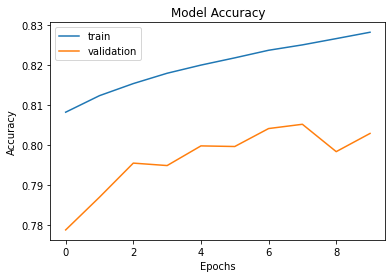

In [33]:
# Training the model 1.2.2 (Version 2)

history_1_2_2_version_2= model_1_2_2_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_1_2_2_version_2)

Epoch 1/10
4096/4096 [==============================] - 105s 25ms/step - loss: 0.1407 - acc: 0.8006 - val_loss: 0.1261 - val_acc: 0.8253
Epoch 2/10
4096/4096 [==============================] - 102s 25ms/step - loss: 0.1002 - acc: 0.8649 - val_loss: 0.1368 - val_acc: 0.8214
Epoch 3/10
4096/4096 [==============================] - 127s 31ms/step - loss: 0.0851 - acc: 0.8871 - val_loss: 0.1677 - val_acc: 0.7661
Epoch 4/10
4096/4096 [==============================] - 124s 30ms/step - loss: 0.0774 - acc: 0.8989 - val_loss: 0.1041 - val_acc: 0.8572
Epoch 5/10
4096/4096 [==============================] - 108s 26ms/step - loss: 0.0739 - acc: 0.9041 - val_loss: 0.1118 - val_acc: 0.8556
Epoch 6/10
4096/4096 [==============================] - 129s 31ms/step - loss: 0.0720 - acc: 0.9070 - val_loss: 0.1217 - val_acc: 0.8309
Epoch 7/10
4096/4096 [==============================] - 105s 26ms/step - loss: 0.0711 - acc: 0.9080 - val_loss: 0.1119 - val_acc: 0.8507
Epoch 8/10
4096/4096 [===================

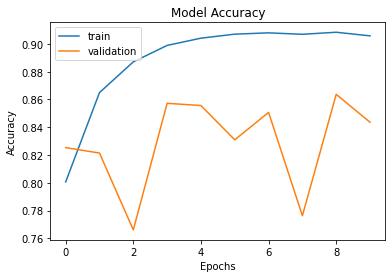

In [30]:
# Training the model 1.2.3 (Version 2)

history_1_2_3_version_2= model_1_2_3_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_1_2_3_version_2)

Epoch 1/10
4096/4096 [==============================] - 105s 25ms/step - loss: 1.0003 - acc: 0.4994 - val_loss: 1.0001 - val_acc: 0.4995
Epoch 2/10
4096/4096 [==============================] - 102s 25ms/step - loss: 1.0004 - acc: 0.4999 - val_loss: 1.0002 - val_acc: 0.4995
Epoch 3/10
4096/4096 [==============================] - 125s 31ms/step - loss: 1.0006 - acc: 0.4998 - val_loss: 1.0003 - val_acc: 0.4995
Epoch 4/10
4096/4096 [==============================] - 126s 31ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 1.0003 - val_acc: 0.4995
Epoch 5/10
4096/4096 [==============================] - 107s 26ms/step - loss: 1.0000 - acc: 0.5001 - val_loss: 1.0003 - val_acc: 0.4995
Epoch 6/10
4096/4096 [==============================] - 128s 31ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 1.0003 - val_acc: 0.4995
Epoch 7/10
4096/4096 [==============================] - 103s 25ms/step - loss: 1.0002 - acc: 0.5000 - val_loss: 1.0004 - val_acc: 0.4995
Epoch 8/10
4096/4096 [===================

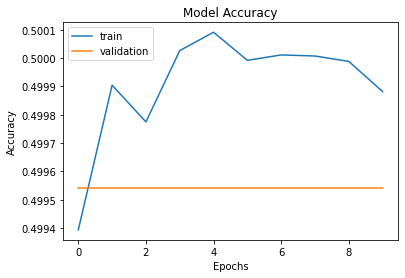

In [31]:
# Training the model 2.1.1 (Version 2)

history_2_1_1_version_2= model_2_1_1_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_2_1_1_version_2)

Epoch 1/10
4096/4096 [==============================] - 105s 25ms/step - loss: 1.0004 - acc: 0.4990 - val_loss: 1.0000 - val_acc: 0.5005
Epoch 2/10
4096/4096 [==============================] - 102s 25ms/step - loss: 0.9998 - acc: 0.5004 - val_loss: 1.0000 - val_acc: 0.5005
Epoch 3/10
4096/4096 [==============================] - 124s 30ms/step - loss: 1.0005 - acc: 0.4983 - val_loss: 1.0000 - val_acc: 0.5005
Epoch 4/10
4096/4096 [==============================] - 123s 30ms/step - loss: 1.0001 - acc: 0.5001 - val_loss: 1.0000 - val_acc: 0.5005
Epoch 5/10
4096/4096 [==============================] - 104s 25ms/step - loss: 0.9999 - acc: 0.4988 - val_loss: 1.0000 - val_acc: 0.5005
Epoch 6/10
4096/4096 [==============================] - 107s 26ms/step - loss: 0.9999 - acc: 0.5004 - val_loss: 1.0000 - val_acc: 0.5005
Epoch 7/10
4096/4096 [==============================] - 107s 26ms/step - loss: 1.0004 - acc: 0.4985 - val_loss: 1.0000 - val_acc: 0.5005
Epoch 8/10
4096/4096 [===================

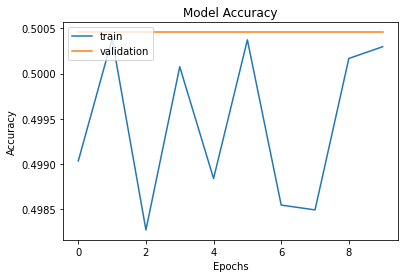

In [36]:
# Training the model 2.1.2 (Version 2)

history_2_1_2_version_2= model_2_1_2_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_2_1_2_version_2)

Epoch 1/10
4096/4096 [==============================] - 107s 26ms/step - loss: 0.9996 - acc: 0.5001 - val_loss: 0.9995 - val_acc: 0.5005
Epoch 2/10
4096/4096 [==============================] - 104s 25ms/step - loss: 1.0008 - acc: 0.4992 - val_loss: 1.0004 - val_acc: 0.4995
Epoch 3/10
4096/4096 [==============================] - 125s 31ms/step - loss: 1.0016 - acc: 0.4984 - val_loss: 0.9996 - val_acc: 0.5005
Epoch 4/10
4096/4096 [==============================] - 103s 25ms/step - loss: 0.9991 - acc: 0.5015 - val_loss: 0.9996 - val_acc: 0.5005
Epoch 5/10
4096/4096 [==============================] - 113s 28ms/step - loss: 1.0006 - acc: 0.5000 - val_loss: 0.9998 - val_acc: 0.5005
Epoch 6/10
4096/4096 [==============================] - 109s 27ms/step - loss: 1.0003 - acc: 0.4998 - val_loss: 1.0005 - val_acc: 0.4995
Epoch 7/10
4096/4096 [==============================] - 109s 27ms/step - loss: 1.0002 - acc: 0.5000 - val_loss: 1.0005 - val_acc: 0.4995
Epoch 8/10
4096/4096 [===================

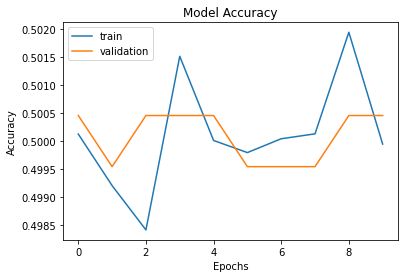

In [49]:
# Training the model 2.1.3 (Version 2)

history_2_1_3_version_2= model_2_1_3_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_2_1_3_version_2)

Epoch 1/10
4096/4096 [==============================] - 104s 25ms/step - loss: 0.2597 - acc: 0.4999 - val_loss: 0.2501 - val_acc: 0.5005
Epoch 2/10
4096/4096 [==============================] - 101s 25ms/step - loss: 0.2528 - acc: 0.4990 - val_loss: 0.2501 - val_acc: 0.5005
Epoch 3/10
4096/4096 [==============================] - 125s 30ms/step - loss: 0.2512 - acc: 0.5005 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 4/10
4096/4096 [==============================] - 124s 30ms/step - loss: 0.2507 - acc: 0.5004 - val_loss: 0.2503 - val_acc: 0.5005
Epoch 5/10
4096/4096 [==============================] - 102s 25ms/step - loss: 0.2505 - acc: 0.4993 - val_loss: 0.2502 - val_acc: 0.5005
Epoch 6/10
4096/4096 [==============================] - 103s 25ms/step - loss: 0.2504 - acc: 0.4998 - val_loss: 0.2502 - val_acc: 0.5005
Epoch 7/10
4096/4096 [==============================] - 106s 26ms/step - loss: 0.2503 - acc: 0.4994 - val_loss: 0.2501 - val_acc: 0.5005
Epoch 8/10
4096/4096 [===================

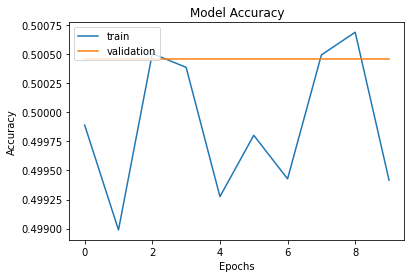

In [50]:
# Training the model 2.2.1 (Version 2)

history_2_2_1_version_2= model_2_2_1_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_2_2_1_version_2)

Epoch 1/10
4096/4096 [==============================] - 105s 25ms/step - loss: 0.2636 - acc: 0.5005 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 2/10
4096/4096 [==============================] - 101s 25ms/step - loss: 0.2606 - acc: 0.5006 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 3/10
4096/4096 [==============================] - 126s 31ms/step - loss: 0.2588 - acc: 0.5002 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 4/10
4096/4096 [==============================] - 126s 31ms/step - loss: 0.2572 - acc: 0.5010 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 5/10
4096/4096 [==============================] - 105s 26ms/step - loss: 0.2568 - acc: 0.4987 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 6/10
4096/4096 [==============================] - 131s 32ms/step - loss: 0.2559 - acc: 0.4990 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 7/10
4096/4096 [==============================] - 105s 26ms/step - loss: 0.2552 - acc: 0.5005 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 8/10
4096/4096 [===================

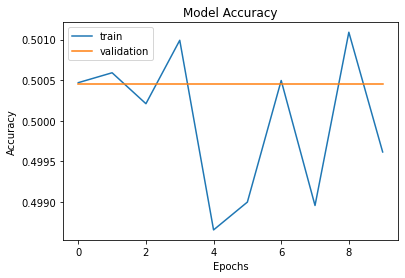

In [51]:
# Training the model 2.2.2 (Version 2)

history_2_2_2_version_2= model_2_2_2_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_2_2_2_version_2)

Epoch 1/10
4096/4096 [==============================] - 106s 25ms/step - loss: 0.2513 - acc: 0.4989 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 2/10
4096/4096 [==============================] - 103s 25ms/step - loss: 0.2500 - acc: 0.5020 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 3/10
4096/4096 [==============================] - 125s 31ms/step - loss: 0.2500 - acc: 0.5022 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 4/10
4096/4096 [==============================] - 104s 25ms/step - loss: 0.2500 - acc: 0.5009 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 5/10
4096/4096 [==============================] - 109s 26ms/step - loss: 0.2500 - acc: 0.5007 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 6/10
4096/4096 [==============================] - 112s 27ms/step - loss: 0.2500 - acc: 0.5006 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 7/10
4096/4096 [==============================] - 106s 26ms/step - loss: 0.2500 - acc: 0.5005 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 8/10
4096/4096 [===================

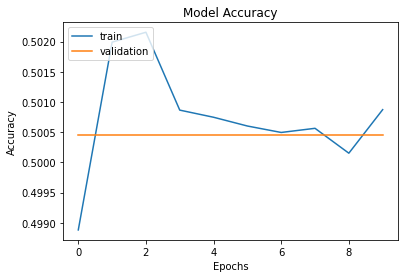

In [52]:
# Training the model 2.2.3 (Version 2)

history_2_2_3_version_2= model_2_2_3_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_2_2_3_version_2)

Epoch 1/10
4096/4096 [==============================] - 106s 25ms/step - loss: 1.0005 - acc: 0.4991 - val_loss: 0.9998 - val_acc: 0.5005
Epoch 2/10
4096/4096 [==============================] - 102s 25ms/step - loss: 1.0001 - acc: 0.4998 - val_loss: 0.9998 - val_acc: 0.5005
Epoch 3/10
4096/4096 [==============================] - 125s 30ms/step - loss: 1.0002 - acc: 0.4993 - val_loss: 0.9998 - val_acc: 0.5005
Epoch 4/10
4096/4096 [==============================] - 105s 26ms/step - loss: 0.9999 - acc: 0.5003 - val_loss: 0.9997 - val_acc: 0.5005
Epoch 5/10
4096/4096 [==============================] - 106s 26ms/step - loss: 1.0008 - acc: 0.4984 - val_loss: 0.9998 - val_acc: 0.5005
Epoch 6/10
4096/4096 [==============================] - 105s 26ms/step - loss: 1.0007 - acc: 0.4985 - val_loss: 0.9997 - val_acc: 0.5005
Epoch 7/10
4096/4096 [==============================] - 109s 27ms/step - loss: 1.0000 - acc: 0.5001 - val_loss: 0.9997 - val_acc: 0.5005
Epoch 8/10
4096/4096 [===================

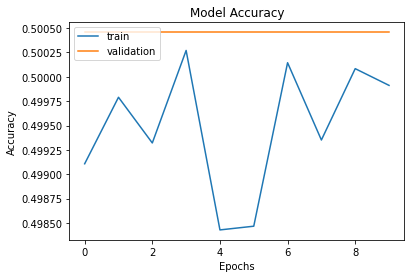

In [53]:
# Training the model 3.1.1 (Version 2)

history_3_1_1_version_2= model_3_1_1_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_3_1_1_version_2)

Epoch 1/10
4096/4096 [==============================] - 107s 26ms/step - loss: 0.9999 - acc: 0.4999 - val_loss: 0.9998 - val_acc: 0.5005
Epoch 2/10
4096/4096 [==============================] - 102s 25ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9998 - val_acc: 0.5005
Epoch 3/10
4096/4096 [==============================] - 126s 31ms/step - loss: 1.0005 - acc: 0.4996 - val_loss: 0.9997 - val_acc: 0.5005
Epoch 4/10
4096/4096 [==============================] - 106s 26ms/step - loss: 1.0002 - acc: 0.4999 - val_loss: 0.9997 - val_acc: 0.5005
Epoch 5/10
4096/4096 [==============================] - 112s 27ms/step - loss: 1.0002 - acc: 0.4999 - val_loss: 0.9997 - val_acc: 0.5005
Epoch 6/10
4096/4096 [==============================] - 110s 27ms/step - loss: 1.0000 - acc: 0.4999 - val_loss: 0.9997 - val_acc: 0.5005
Epoch 7/10
4096/4096 [==============================] - 111s 27ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 0.9997 - val_acc: 0.5005
Epoch 8/10
4096/4096 [===================

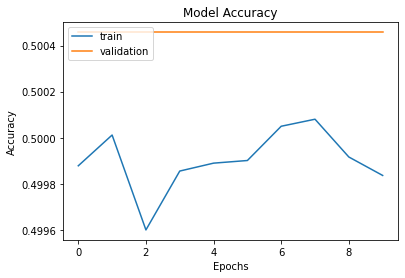

In [54]:
# Training the model 3.1.2 (Version 2)

history_3_1_2_version_2= model_3_1_2_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_3_1_2_version_2)

Epoch 1/10
4096/4096 [==============================] - 109s 26ms/step - loss: 1.0001 - acc: 0.5001 - val_loss: 1.0000 - val_acc: 0.5005
Epoch 2/10
4096/4096 [==============================] - 105s 26ms/step - loss: 1.0008 - acc: 0.4991 - val_loss: 0.9999 - val_acc: 0.5005
Epoch 3/10
4096/4096 [==============================] - 106s 26ms/step - loss: 1.0009 - acc: 0.4988 - val_loss: 1.0003 - val_acc: 0.4995
Epoch 4/10
4096/4096 [==============================] - 113s 28ms/step - loss: 0.9996 - acc: 0.5009 - val_loss: 1.0004 - val_acc: 0.4995
Epoch 5/10
4096/4096 [==============================] - 110s 27ms/step - loss: 0.9999 - acc: 0.5001 - val_loss: 1.0005 - val_acc: 0.4995
Epoch 6/10
4096/4096 [==============================] - 117s 29ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 1.0005 - val_acc: 0.4995
Epoch 7/10
4096/4096 [==============================] - 106s 26ms/step - loss: 1.0000 - acc: 0.5000 - val_loss: 1.0005 - val_acc: 0.4995
Epoch 8/10
4096/4096 [===================

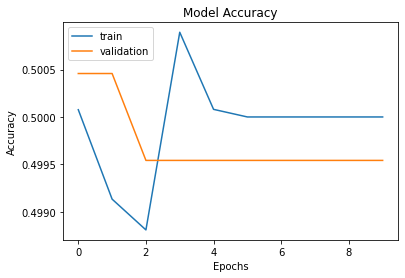

In [55]:
# Training the model 3.1.3 (Version 2)

history_3_1_3_version_2= model_3_1_3_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_3_1_3_version_2)

Epoch 1/10
4096/4096 [==============================] - 106s 26ms/step - loss: 0.2556 - acc: 0.4999 - val_loss: 0.2501 - val_acc: 0.5005
Epoch 2/10
4096/4096 [==============================] - 102s 25ms/step - loss: 0.2514 - acc: 0.5009 - val_loss: 0.2502 - val_acc: 0.5005
Epoch 3/10
4096/4096 [==============================] - 124s 30ms/step - loss: 0.2506 - acc: 0.5012 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 4/10
4096/4096 [==============================] - 123s 30ms/step - loss: 0.2505 - acc: 0.4997 - val_loss: 0.2501 - val_acc: 0.5005
Epoch 5/10
4096/4096 [==============================] - 107s 26ms/step - loss: 0.2504 - acc: 0.4989 - val_loss: 0.2501 - val_acc: 0.5005
Epoch 6/10
4096/4096 [==============================] - 128s 31ms/step - loss: 0.2503 - acc: 0.4999 - val_loss: 0.2506 - val_acc: 0.5005
Epoch 7/10
4096/4096 [==============================] - 132s 32ms/step - loss: 0.2503 - acc: 0.5016 - val_loss: 0.2503 - val_acc: 0.5005
Epoch 8/10
4096/4096 [===================

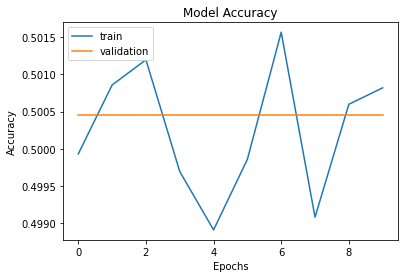

In [56]:
# Training the model 3.2.1 (Version 2)

history_3_2_1_version_2= model_3_2_1_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_3_2_1_version_2)

Epoch 1/10
4096/4096 [==============================] - 105s 25ms/step - loss: 0.2608 - acc: 0.5009 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 2/10
4096/4096 [==============================] - 101s 25ms/step - loss: 0.2571 - acc: 0.4999 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 3/10
4096/4096 [==============================] - 124s 30ms/step - loss: 0.2553 - acc: 0.4988 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 4/10
4096/4096 [==============================] - 125s 31ms/step - loss: 0.2541 - acc: 0.5008 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 5/10
4096/4096 [==============================] - 111s 27ms/step - loss: 0.2535 - acc: 0.4981 - val_loss: 0.2501 - val_acc: 0.5005
Epoch 6/10
4096/4096 [==============================] - 129s 31ms/step - loss: 0.2528 - acc: 0.5012 - val_loss: 0.2501 - val_acc: 0.5005
Epoch 7/10
4096/4096 [==============================] - 106s 26ms/step - loss: 0.2524 - acc: 0.5007 - val_loss: 0.2501 - val_acc: 0.5005
Epoch 8/10
4096/4096 [===================

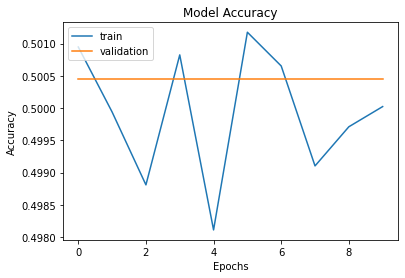

In [57]:
# Training the model 3.2.2 (Version 2)

history_3_2_2_version_2= model_3_2_2_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_3_2_2_version_2)

Epoch 1/10
4096/4096 [==============================] - 105s 25ms/step - loss: 0.2519 - acc: 0.4986 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 2/10
4096/4096 [==============================] - 102s 25ms/step - loss: 0.2502 - acc: 0.5012 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 3/10
4096/4096 [==============================] - 125s 30ms/step - loss: 0.2502 - acc: 0.5009 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 4/10
4096/4096 [==============================] - 122s 30ms/step - loss: 0.2501 - acc: 0.5011 - val_loss: 0.2503 - val_acc: 0.5005
Epoch 5/10
4096/4096 [==============================] - 104s 25ms/step - loss: 0.2501 - acc: 0.5008 - val_loss: 0.2500 - val_acc: 0.5005
Epoch 6/10
4096/4096 [==============================] - 105s 26ms/step - loss: 0.2501 - acc: 0.4993 - val_loss: 0.2502 - val_acc: 0.5005
Epoch 7/10
4096/4096 [==============================] - 106s 26ms/step - loss: 0.2502 - acc: 0.4990 - val_loss: 0.2501 - val_acc: 0.5005
Epoch 8/10
4096/4096 [===================

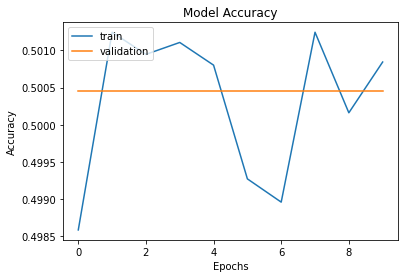

In [58]:
# Training the model 3.2.3 (Version 2)

history_3_2_3_version_2= model_3_2_3_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)
plot_hist(history_3_2_3_version_2)

In [59]:
# Testing the models

print("Test dataset accuracy for model 1.1.1 version 2 is: {0:.4f}".format(model_1_1_1_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 1.1.2 version 2 is: {0:.4f}".format(model_1_1_2_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 1.1.3 version 2 is: {0:.4f}".format(model_1_1_3_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))

print("Test dataset accuracy for model 1.2.1 version 2 is: {0:.4f}".format(model_1_2_1_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 1.2.2 version 2 is: {0:.4f}".format(model_1_2_2_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 1.2.3 version 2 is: {0:.4f}".format(model_1_2_3_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))


print("Test dataset accuracy for model 2.1.1 version 2 is: {0:.4f}".format(model_2_1_1_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 2.1.2 version 2 is: {0:.4f}".format(model_2_1_2_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 2.1.3 version 2 is: {0:.4f}".format(model_2_1_3_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))

print("Test dataset accuracy for model 2.2.1 version 2 is: {0:.4f}".format(model_2_2_1_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 2.2.2 version 2 is: {0:.4f}".format(model_2_2_2_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 2.2.3 version 2 is: {0:.4f}".format(model_2_2_3_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))

print("Test dataset accuracy for model 3.1.1 version 2 is: {0:.4f}".format(model_3_1_1_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 3.1.2 version 2 is: {0:.4f}".format(model_3_1_2_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 3.1.3 version 2 is: {0:.4f}".format(model_3_1_3_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))

print("Test dataset accuracy for model 3.2.1 version 2 is: {0:.4f}".format(model_3_2_1_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 3.2.2 version 2 is: {0:.4f}".format(model_3_2_2_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))
print("Test dataset accuracy for model 3.2.3 version 2 is: {0:.4f}".format(model_3_2_3_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))



256/256 [==============================] - 10s 38ms/step - loss: 0.6965 - acc: 0.8030
Test dataset accuracy for model 1.1.1 version 2 is: 0.8030
256/256 [==============================] - 9s 35ms/step - loss: 0.7459 - acc: 0.7552
Test dataset accuracy for model 1.1.2 version 2 is: 0.7552
256/256 [==============================] - 9s 34ms/step - loss: 0.9998 - acc: 0.5002
Test dataset accuracy for model 1.1.3 version 2 is: 0.5002
256/256 [==============================] - 9s 35ms/step - loss: 0.1745 - acc: 0.7535
Test dataset accuracy for model 1.2.1 version 2 is: 0.7535
256/256 [==============================] - 9s 35ms/step - loss: 0.1402 - acc: 0.8019
Test dataset accuracy for model 1.2.2 version 2 is: 0.8019
256/256 [==============================] - 9s 35ms/step - loss: 0.1428 - acc: 0.8315
Test dataset accuracy for model 1.2.3 version 2 is: 0.8315
256/256 [==============================] - 9s 35ms/step - loss: 1.0001 - acc: 0.4998
Test dataset accuracy for model 2.1.1 version 2 is